Number of image in json file

In [7]:
import json
import os
from collections import defaultdict

base_path = 'noaug/annotations/'
splits = ['train', 'val', 'test']
categories = ['ba', 'eo', 'erb', 'ig', 'lym', 'mono', 'neut', 'platelet']

def analyze_split(split):
    json_path = os.path.join(base_path, f'{split}.json')
    if not os.path.exists(json_path):
        print(f"Error: {json_path} not found.")
        return 0, defaultdict(set)
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    total_images = len(data['images'])
    
    category_map = {cat['id']: cat['name'] for cat in data['categories']}

    images_per_category = defaultdict(set)
    for ann in data['annotations']:
        image_id = ann['image_id']
        category_id = ann['category_id']
        category_name = category_map.get(category_id, 'unknown')
        images_per_category[category_name].add(image_id)
    
    return total_images, images_per_category

total_dataset_images = 0
for split in splits:
    total_images, images_per_category = analyze_split(split)
    total_dataset_images += total_images
    
    print(f"\nSplit: {split}")
    print(f"Total Images: {total_images}")
    print("Images per Category:")
    for cat in categories:
        num_images = len(images_per_category[cat])
        print(f"  {cat}: {num_images} images")
    
print(f"\nTotal Images in Dataset: {total_dataset_images}")


Split: train
Total Images: 11458
Images per Category:
  ba: 494 images
  eo: 2209 images
  erb: 905 images
  ig: 2122 images
  lym: 604 images
  mono: 786 images
  neut: 2702 images
  platelet: 3542 images

Split: val
Total Images: 2100
Images per Category:
  ba: 300 images
  eo: 300 images
  erb: 300 images
  ig: 300 images
  lym: 306 images
  mono: 305 images
  neut: 321 images
  platelet: 1796 images

Split: test
Total Images: 2100
Images per Category:
  ba: 300 images
  eo: 301 images
  erb: 302 images
  ig: 303 images
  lym: 307 images
  mono: 304 images
  neut: 326 images
  platelet: 1781 images

Total Images in Dataset: 15658


Show a specific image

In [9]:
from PIL import Image

image = Image.open("noaug/train/BA_214889.jpg") 

image.show()


Opening in existing browser session.


Show each class a image with bbox

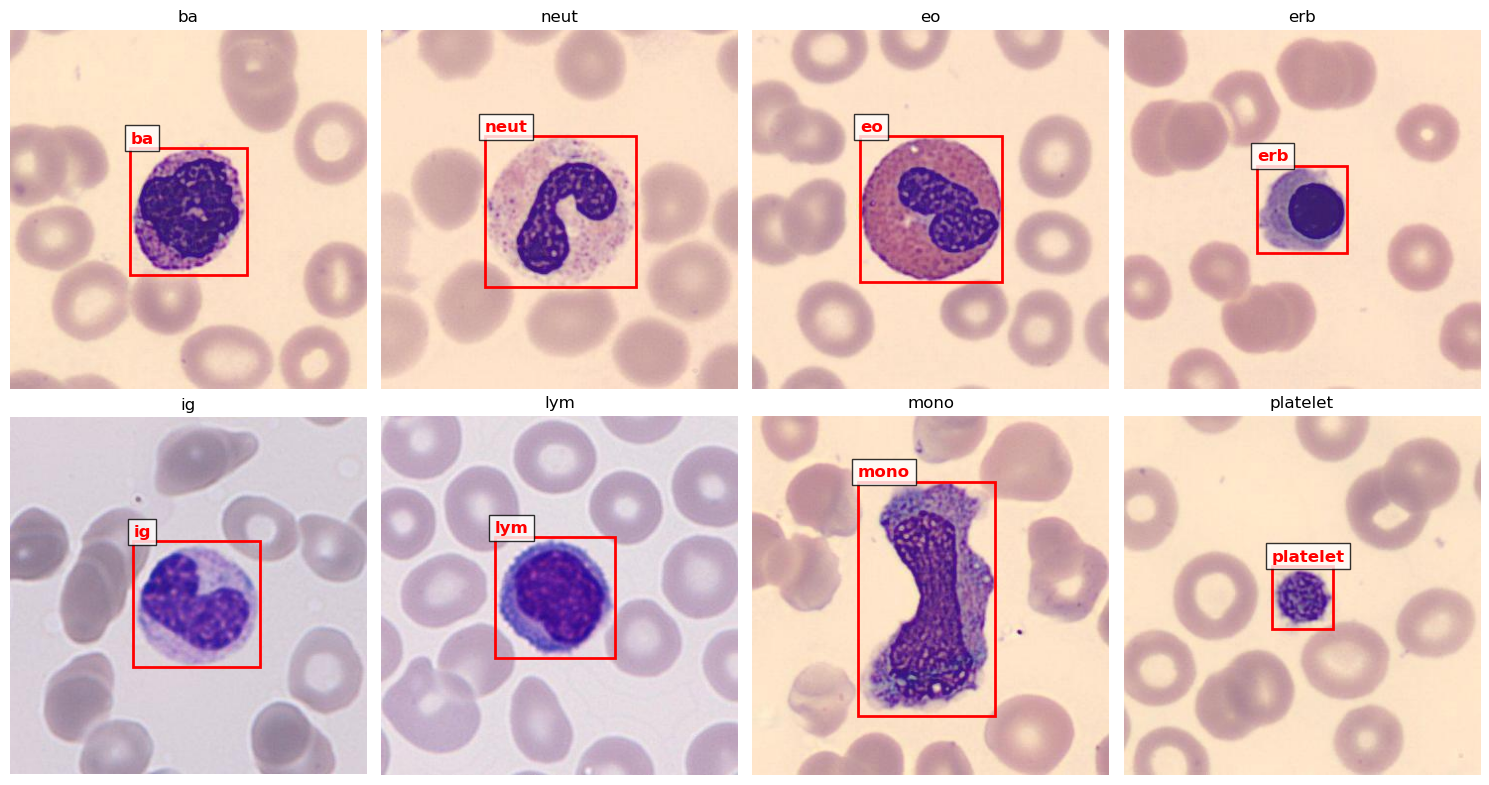

In [ ]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths
data_dir = 'noaug2/augmented'
ann_file = os.path.join(data_dir, 'annotations', 'train_augmented.json')
image_dir = os.path.join(data_dir, 'train')

# Load JSON annotations
with open(ann_file, 'r') as f:
    data = json.load(f)

# Extract images, annotations, and categories
images = data['images']
annotations = data['annotations']
categories = data['categories']

# Create a mapping of category ID to name
category_map = {cat['id']: cat['name'] for cat in categories}

# Find one image per category
category_to_image = {}
for ann in annotations:
    cat_id = ann['category_id']
    if cat_id not in category_to_image:
        # Find the image corresponding to this annotation
        image_id = ann['image_id']
        image_info = next((img for img in images if img['id'] == image_id), None)
        if image_info:
            category_to_image[cat_id] = {
                'image_info': image_info,
                'bbox': ann['bbox'],
                'category_name': category_map[cat_id]
            }
    # Stop once we have one image per category
    if len(category_to_image) == len(categories):
        break

# Plot one image per category
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2x4 grid for 8 categories
axes = axes.flatten()  # Flatten for easier iteration

for idx, (cat_id, info) in enumerate(category_to_image.items()):
    # Load image
    image_path = os.path.join(image_dir, info['image_info']['file_name'])
    if not os.path.exists(image_path):
        print(f"Image {image_path} not found, skipping...")
        continue
    image = Image.open(image_path)

    # Plot image
    ax = axes[idx]
    ax.imshow(image)

    # Add bounding box
    bbox = info['bbox']
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

    # Add category label
    ax.text(
        bbox[0], bbox[1] - 5, info['category_name'],
        color='r', fontsize=12, weight='bold',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Set title and remove axes
    ax.set_title(info['category_name'])
    ax.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Show a specific image with bbox

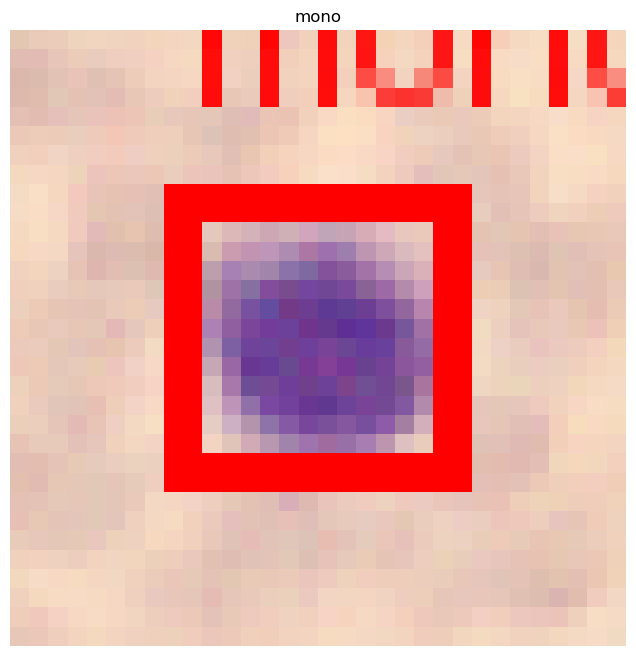

In [17]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Paths to dataset
annotation_file = 'noaug2/augmented/annotations/train_augmented.json'  # Update to val.json or test.json if needed
image_dir = 'noaug2/augmented/train'  # Update to val or test if needed
# image_file = 'SNE_989373.jpg'  # The image to visualize
image_file = 'synthetic_6_492.png'  # The image to visualize
# image_file = 'ERB_312715.jpg'

# Load JSON annotations
with open(annotation_file, 'r') as f:
    data = json.load(f)

# Find the image info
image_info = next((img for img in data['images'] if img['file_name'] == image_file), None)
if not image_info:
    raise FileNotFoundError(f"Image {image_file} not found in {annotation_file}")

# Load the image
image_path = os.path.join(image_dir, image_file)
image = Image.open(image_path)

# Get annotations for this image
image_id = image_info['id']
annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]

# Create a draw object
draw = ImageDraw.Draw(image)

# Try to use a font (optional, for label display)
try:
    font = ImageFont.truetype("arial.ttf", 15)  # Use default font or specify path
except:
    font = ImageFont.load_default()

# Collect unique category names for the title
category_names = set()
for ann in annotations:
    category_id = ann['category_id']
    category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == category_id)
    category_names.add(category_name)
    bbox = ann['bbox']  # [x_min, y_min, width, height]
    
    # Convert bbox to [x_min, y_min, x_max, y_max] for drawing
    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height
    
    # Draw rectangle
    draw.rectangle((x_min, y_min, x_max, y_max), outline='red', width=2)
    
    # Draw label
    label = f"{category_name}"
    draw.text((x_min, y_min - 15), label, fill='red', font=font)

# Create title from unique category names
title = ", ".join(category_names) if category_names else "No Annotations"

# Convert PIL image to array for matplotlib display
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(title)  # Set title to category name(s)
plt.show()

create a set with no multi-annotation image

In [ ]:
import json
import os

# Paths
json_path = 'noaug/annotations/train.json'
train_dir = 'noaug/train'

with open(json_path, 'r') as f:
    data = json.load(f)

image_annotation_count = {}
for ann in data['annotations']:
    image_id = ann['image_id']
    image_annotation_count[image_id] = image_annotation_count.get(image_id, 0) + 1

multi_annotation_image_ids = [image_id for image_id, count in image_annotation_count.items() if count > 1]

images_to_keep = [img for img in data['images'] if img['id'] not in multi_annotation_image_ids]
annotations_to_keep = [ann for ann in data['annotations'] if ann['image_id'] not in multi_annotation_image_ids]

for img in data['images']:
    if img['id'] in multi_annotation_image_ids:
        image_path = os.path.join(train_dir, img['file_name'])
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted image: {image_path}")
        else:
            print(f"Image not found: {image_path}")

updated_data = {
    'images': images_to_keep,
    'annotations': annotations_to_keep,
    'categories': data['categories'] 
}

with open(json_path, 'w') as f:
    json.dump(updated_data, f, indent=4)
    print(f"Updated JSON file: {json_path}")

print(f"Removed {len(data['images']) - len(images_to_keep)} images with multiple annotations.")
print(f"Kept {len(images_to_keep)} images and {len(annotations_to_keep)} annotations.")

Created noaug2 with 8816 images and 8816 annotations
